# Do closed businesses have more negative reviews?

In [1]:
%pip install flair==0.13.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set_theme()

from flair.data import Sentence
from flair.nn import Classifier

/Users/joeylim/miniconda3/envs/sc1015/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
reviews = pd.read_parquet("https://ntu-sc1015-yelp.s3.ap-southeast-1.amazonaws.com/yelp_reviews_inner.parquet/part-00000-tid-2558117656403601659-b3029da0-4c99-4b8b-8c7a-cdb7db9371e5-1209-1-c000.snappy.parquet")
reviews.head()

,user_id,business_id,cool,date,funny,review_id,stars,text,useful,business_address,...,user_compliment_writer,user_cool,user_elite,user_fans,user_friends,user_funny,user_name,user_review_count,user_useful,user_yelping_since
0,-3-GR6zLPQUQXC02xE5QaA,Kfaq9cuyeXHkzWwL39jUWw,0,2022-01-08,0,5teG7qQ0oxQNRhXTkTV-AA,5.0,"If you leave hungry, it's your own fault. Ther...",0,311 Salem Pl,...,0,5,,0,"vm2DaLbzM9KxVjDU6gmMRQ, H5fheR7XkbgdOhUD2KijTw...",3,Tracey,41,14,2016-01-25 22:20:02
1,-5Qgwxo8lTJQdadtJY879w,9CRWWbw3iOo4-9FMAO6nKw,0,2021-12-31,0,yhJplqlngFVTFk5W_velmQ,5.0,They where able to provide very good sandwiche...,0,1302 Magazine St,...,0,0,,0,None,0,Mike,4,1,2020-10-28 01:46:43
2,-5Qgwxo8lTJQdadtJY879w,SJIQFKTW6uUsOo29w9IHxw,0,2021-12-31,0,Q90M8AHlNxUVL0ii7MAj1w,5.0,Was able to have very tasty po boy alligator a...,0,411 Bourbon St,...,0,0,,0,None,0,Mike,4,1,2020-10-28 01:46:43
3,-6J6EFoigdncrbw586jAQg,gP_oWJykA2RocIs_GurKWQ,0,2021-11-20,0,FkuvWGHoqveIKmG2JjuEXg,5.0,"While shopping in the area, we decided to try ...",0,"2000 Mallory Ln, Ste 615",...,0,0,,0,"7SwgKCa2IYP2tmxxDpuwaw, vwRUqCoINjuBdozwgvVCxA...",0,Paige,1,0,2021-11-20 18:40:41
4,-9q7GFmibqq3E6W0Bw3_jQ,gJSNa1bxwtY0dm1t-dh38w,0,2022-01-13,0,P7zB0L55i7zwFt3vjAa8lw,1.0,Food was horrible. Hot and sour soup had no fl...,0,219 Westshore Plz,...,0,0,,0,"BtUw263un2hRPQ7OvEF-8g, gh7JzS4v_xiTGUOG2kjLkQ...",0,Diana,2,5,2011-01-21 21:14:45


In [4]:
reviews.shape

(99967, 43)

# EDA on Reviews

In [5]:
import re

def count_words(text):
    words = re.findall(r'\b\w+(?:\'\w+)?\b', text)
    # Count number of words
    word_count = len(words)
    return word_count


### Length of Reviews based on word count

In [6]:
reviews['text_length'] = reviews['text'].apply(count_words)
pd.set_option('display.max_colwidth', None)
reviews.head(10)

,user_id,business_id,cool,date,funny,review_id,stars,text,useful,business_address,...,user_cool,user_elite,user_fans,user_friends,user_funny,user_name,user_review_count,user_useful,user_yelping_since,text_length
0,-3-GR6zLPQUQXC02xE5QaA,Kfaq9cuyeXHkzWwL39jUWw,0,2022-01-08,0,5teG7qQ0oxQNRhXTkTV-AA,5.0,"If you leave hungry, it's your own fault. There were 8 of us. All left happy and with leftovers. So good.",0,311 Salem Pl,...,5,,0,"vm2DaLbzM9KxVjDU6gmMRQ, H5fheR7XkbgdOhUD2KijTw, L_y0rqz7poPgbDRilOkdlQ, 7YrATh7GzZY6uQsVhJuhbQ, HyVrE0aWuh_vRkt0lSEN1Q, KFLKDO2lL2yqvHmAUcTJ7w, rxd0s-vUWp_8w6A97DleZg, sKAKB5xWsDcfKHKlvrGOIQ, ueKFDrWiM1Y2u7eOy04d4A, VXBW5169D7Ti2U7TwJjBHA, dcCxWTqnvaUTyqSxWuQf1g, lVT8q3he51X3Qg2E6lBquQ, SBpERfJfblzZLeiyptMz2w, aTNA2RxrrB2miAU1GMchYA, mTaf879VqxlSU31xRx6W3w, KOtQmZctTLVAm80rSzzJOQ, F0_MhbojiKvnmkxrnk7zEg, E5wkEkQFLJKoTZWb79Gnjg, QZuZSvuHtauLlUxcBtMp8g, 4Na52UNbHX-G8AeaH8WSlg, syUzpfLOxEHeuqsmi72W9A, jnMIgMQOxzUC9KMRS64fWg, yhXT_PYyYXos5dM7IrPCQg, uAOqMHULwFYICpCigSyK6A, ePl_fNcA2ABvS5BUYo0C6w, JUyde69wO2oC4ozeZGzKCA, JBjBf-8Gsa9vyx4yml1PZw, b2sMN0QeYyQp_iYPIb0yuQ, rOkUuBginV3Sr61vtxd7Qw, 6r9TBZlC_V1BD4vTzlKq8w, bmED5WuWAZrI8IGtVXXNpQ, KqOGONdFAo_eSdGnc6ruIg, G-zPuiL2URu5T_wJIwSXDw, ZwSJ5BVmMtJHcXQDfh-PyQ, to-ni2ifG9j6iwtq7E50ug, bsPcsyUSBg_aemjHCMnbDw, IWvleAnnjbelSV8aN_qHEg, sXKxvsHLqk88uyhK728kEg, uYuiyQD0qpVRjrac-QQBZA, OFe73cPte5Enk0rcawH0bw, h-yrJNTNBV56NuA4WgRWtA, qkO8zTnAsF_ysffY9JzVjg, p1exgUVJiCpTpWo0WQcgFg, v3_fq-tKYkHyzDoL5fOkzw, dKwq3_Wj6GWFMlHmAzSq3g, JN_vF-Tfm3rB0zXzYBdv_Q, qrO2nLUggs3fImgAq83htw, _499yDvYdSM_V9wTf9dQrA, lMgbFSKDOC7yaw2SaZ12nw, cM3cR0nx-zMfd2CFIuGPYw, IAGF32FB5PnRzokuQRCmmQ, IyrwcLy3K4xw4eJjyOr8jw, l4PYiNU7_o2wcCI03CxTFQ, gUVCKXf1BTxKP7Kk-veNcg, XFRyd2Ne3EU60pDbO6Vwtg, 5szV9w9eZBz1Pyk3Nk2B4g, 6NKTtNa19gD9GcUhhmLnmA, M_MBF9Y38c79Ip2IobYxLg, LF1usk2K-FrDEaLlC1xoTA, m30ydvtdr8cFze_zF7ci3w, r4M2dQt82olDzIsrq4cKlg, wdRJ7OV0Ry1nL6NL9eybpQ, 8Vwj8ZnijPLR54OJqEbrJA, V3EZxvhj12ALj906ci-TcQ, yBQpEDMcvH64rnVUQo-khQ, 9FHU3oMSLKNaa-VZNrX5IQ, 2vekpPatwG8Vc56_MWj7JQ, jxFONPtDnRdKXGQqm_pTug, lGe8WhIjIU3qMM1LVlV-KQ, HZFbWnhdNUsSnLsX0YRm9Q, vLf7ntp7hWSKU8rsoU267w, OxQkyghx-KoX9oYTKM-Gqg, UV_ZtxTwCqKI4ADIRNzXnw, rTcJeiQpM6eGfyParz2mfA, 0jHj0Fd9SLswFzysF1dVbQ, 4IgUlh9dVii-3PYfJ6BKDw, rpnzkIDl8_K85SJOGbIZ_A, vcuN-CkKB4Q5X992LonGgA, Im2LKyCwgJkId3RjIcGUJQ, KIIX4Dub9V-8C7amT4dmuw, D3oaQUerBFj-PSUi9xuGQA, vVNbM6tJC58Xzxl-uzvPUQ, 3xFYdpGpqog3jHnW9BwvbQ, KltR5rCVlRvPnMKCglH4pw, OV0HHIQSw2eC88tQBeDwDQ, tXQcH_xXa6uacDoXWdMpMQ, H5UlDj4yTyYuDukYBpE3-g, 949TOANUSLHncVLV8l1lRw, mpU2eWzjPBhm3yLYlbzOBA, 26Ne7gFJJuMN_Plyo5faRA, cthGBGVvkBMNEiNGxLaXBQ, eyiDUqHoyNttZ2HuqcKOUQ, E2_y87YAB-2_Y9kU0Dh8Qw, f67tQlYtKH3_EaAGZbp9aw, gr8NiB4bSlRh-iiFqsyN1w",3,Tracey,41,14,2016-01-25 22:20:02,21
1,-5Qgwxo8lTJQdadtJY879w,9CRWWbw3iOo4-9FMAO6nKw,0,2021-12-31,0,yhJplqlngFVTFk5W_velmQ,5.0,"They where able to provide very good sandwiches, paninis, burgers for a group of 6 adults. Everyone was very happy with there meal and drinks. Would definitely recommend",0,1302 Magazine St,...,0,,0,None,0,Mike,4,1,2020-10-28 01:46:43,28
2,-5Qgwxo8lTJQdadtJY879w,SJIQFKTW6uUsOo29w9IHxw,0,2021-12-31,0,Q90M8AHlNxUVL0ii7MAj1w,5.0,Was able to have very tasty po boy alligator and fish. Service at the bar was fabulous and quick,0,411 Bourbon St,...,0,,0,None,0,Mike,4,1,2020-10-28 01:46:43,19
3,-6J6EFoigdncrbw586jAQg,gP_oWJykA2RocIs_GurKWQ,0,2021-11-20,0,FkuvWGHoqveIKmG2JjuEXg,5.0,"While shopping in the area, we decided to try Yats for something different. Great choice! Love the food! Very authentic! The emphasis is on great service and great food. Definitely recommend this place!",0,"2000 Mallory Ln, Ste 615",...,0,,0,"7SwgKCa2IYP2tmxxDpuwaw, vwRUqCoINjuBdozwgvVCxA, k5ERIPesXtlG_ZwV_4x8Cw, sTIXHM8SG2xsffbr4VFOKQ, xC7j_iQThneBHfrK0znCcw, JXUv61WzdqnSbZ-i-A5IvQ",0,Paige,1,0,2021-11-20 18:40:41,33
4,-9q7GFmibqq3E6W0Bw3_jQ,gJSNa1bxwtY0dm1t-dh38w,0,2022-01-13,0,P7zB0L55i7zwFt3vjAa8lw,1.0,Food was horrible. Hot and sour soup had no flavor. Egg rolls w

<Axes: >

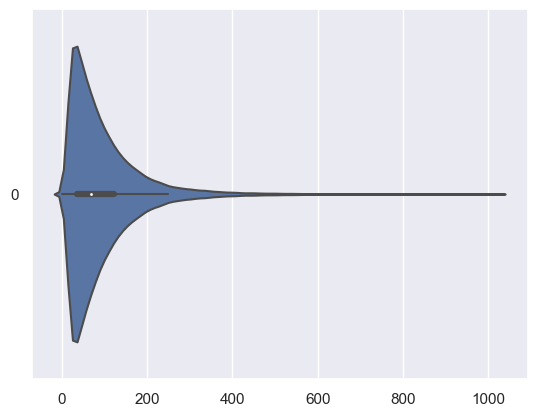

In [7]:
sb.violinplot(data=reviews['text_length'], orient='h')

In [8]:
reviews['text_length'].describe()

count    99967.00000
mean        95.51495
std         90.36863
min          1.00000
25%         37.00000
50%         68.00000
75%        122.00000
max       1021.00000
Name: text_length, dtype: float64

Hence, most of the reviews were short, within 37-122 words long

## Deriving Sentiment from Reviews

In [9]:
tagger = Classifier.load('sentiment-fast')

In [10]:
sentence_list = []
for index, row in reviews.iterrows():
  sentence_list.append(Sentence(row['text']))

In [11]:
tagger.predict(sentence_list, mini_batch_size=1000, verbose=True)

Batch inference: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


In [12]:
sentiment_values = []
sentiment_score = []
for sentence in sentence_list:
  labels = sentence.labels[0]
  sentiment_values.append(labels.value)
  sentiment_score.append(labels.score)

In [13]:
reviews["sentiment_value"] = pd.Series(sentiment_values)
reviews["sentiment_score"] = pd.Series(sentiment_score)

In [14]:
reviews.head()

,user_id,business_id,cool,date,funny,review_id,stars,text,useful,business_address,...,user_fans,user_friends,user_funny,user_name,user_review_count,user_useful,user_yelping_since,text_length,sentiment_value,sentiment_score
0,-3-GR6zLPQUQXC02xE5QaA,Kfaq9cuyeXHkzWwL39jUWw,0,2022-01-08,0,5teG7qQ0oxQNRhXTkTV-AA,5.0,"If you leave hungry, it's your own fault. There were 8 of us. All left happy and with leftovers. So good.",0,311 Salem Pl,...,0,"vm2DaLbzM9KxVjDU6gmMRQ, H5fheR7XkbgdOhUD2KijTw, L_y0rqz7poPgbDRilOkdlQ, 7YrATh7GzZY6uQsVhJuhbQ, HyVrE0aWuh_vRkt0lSEN1Q, KFLKDO2lL2yqvHmAUcTJ7w, rxd0s-vUWp_8w6A97DleZg, sKAKB5xWsDcfKHKlvrGOIQ, ueKFDrWiM1Y2u7eOy04d4A, VXBW5169D7Ti2U7TwJjBHA, dcCxWTqnvaUTyqSxWuQf1g, lVT8q3he51X3Qg2E6lBquQ, SBpERfJfblzZLeiyptMz2w, aTNA2RxrrB2miAU1GMchYA, mTaf879VqxlSU31xRx6W3w, KOtQmZctTLVAm80rSzzJOQ, F0_MhbojiKvnmkxrnk7zEg, E5wkEkQFLJKoTZWb79Gnjg, QZuZSvuHtauLlUxcBtMp8g, 4Na52UNbHX-G8AeaH8WSlg, syUzpfLOxEHeuqsmi72W9A, jnMIgMQOxzUC9KMRS64fWg, yhXT_PYyYXos5dM7IrPCQg, uAOqMHULwFYICpCigSyK6A, ePl_fNcA2ABvS5BUYo0C6w, JUyde69wO2oC4ozeZGzKCA, JBjBf-8Gsa9vyx4yml1PZw, b2sMN0QeYyQp_iYPIb0yuQ, rOkUuBginV3Sr61vtxd7Qw, 6r9TBZlC_V1BD4vTzlKq8w, bmED5WuWAZrI8IGtVXXNpQ, KqOGONdFAo_eSdGnc6ruIg, G-zPuiL2URu5T_wJIwSXDw, ZwSJ5BVmMtJHcXQDfh-PyQ, to-ni2ifG9j6iwtq7E50ug, bsPcsyUSBg_aemjHCMnbDw, IWvleAnnjbelSV8aN_qHEg, sXKxvsHLqk88uyhK728kEg, uYuiyQD0qpVRjrac-QQBZA, OFe73cPte5Enk0rcawH0bw, h-yrJNTNBV56NuA4WgRWtA, qkO8zTnAsF_ysffY9JzVjg, p1exgUVJiCpTpWo0WQcgFg, v3_fq-tKYkHyzDoL5fOkzw, dKwq3_Wj6GWFMlHmAzSq3g, JN_vF-Tfm3rB0zXzYBdv_Q, qrO2nLUggs3fImgAq83htw, _499yDvYdSM_V9wTf9dQrA, lMgbFSKDOC7yaw2SaZ12nw, cM3cR0nx-zMfd2CFIuGPYw, IAGF32FB5PnRzokuQRCmmQ, IyrwcLy3K4xw4eJjyOr8jw, l4PYiNU7_o2wcCI03CxTFQ, gUVCKXf1BTxKP7Kk-veNcg, XFRyd2Ne3EU60pDbO6Vwtg, 5szV9w9eZBz1Pyk3Nk2B4g, 6NKTtNa19gD9GcUhhmLnmA, M_MBF9Y38c79Ip2IobYxLg, LF1usk2K-FrDEaLlC1xoTA, m30ydvtdr8cFze_zF7ci3w, r4M2dQt82olDzIsrq4cKlg, wdRJ7OV0Ry1nL6NL9eybpQ, 8Vwj8ZnijPLR54OJqEbrJA, V3EZxvhj12ALj906ci-TcQ, yBQpEDMcvH64rnVUQo-khQ, 9FHU3oMSLKNaa-VZNrX5IQ, 2vekpPatwG8Vc56_MWj7JQ, jxFONPtDnRdKXGQqm_pTug, lGe8WhIjIU3qMM1LVlV-KQ, HZFbWnhdNUsSnLsX0YRm9Q, vLf7ntp7hWSKU8rsoU267w, OxQkyghx-KoX9oYTKM-Gqg, UV_ZtxTwCqKI4ADIRNzXnw, rTcJeiQpM6eGfyParz2mfA, 0jHj0Fd9SLswFzysF1dVbQ, 4IgUlh9dVii-3PYfJ6BKDw, rpnzkIDl8_K85SJOGbIZ_A, vcuN-CkKB4Q5X992LonGgA, Im2LKyCwgJkId3RjIcGUJQ, KIIX4Dub9V-8C7amT4dmuw, D3oaQUerBFj-PSUi9xuGQA, vVNbM6tJC58Xzxl-uzvPUQ, 3xFYdpGpqog3jHnW9BwvbQ, KltR5rCVlRvPnMKCglH4pw, OV0HHIQSw2eC88tQBeDwDQ, tXQcH_xXa6uacDoXWdMpMQ, H5UlDj4yTyYuDukYBpE3-g, 949TOANUSLHncVLV8l1lRw, mpU2eWzjPBhm3yLYlbzOBA, 26Ne7gFJJuMN_Plyo5faRA, cthGBGVvkBMNEiNGxLaXBQ, eyiDUqHoyNttZ2HuqcKOUQ, E2_y87YAB-2_Y9kU0Dh8Qw, f67tQlYtKH3_EaAGZbp9aw, gr8NiB4bSlRh-iiFqsyN1w",3,Tracey,41,14,2016-01-25 22:20:02,21,POSITIVE,0.846753
1,-5Qgwxo8lTJQdadtJY879w,9CRWWbw3iOo4-9FMAO6nKw,0,2021-12-31,0,yhJplqlngFVTFk5W_velmQ,5.0,"They where able to provide very good sandwiches, paninis, burgers for a group of 6 adults. Everyone was very happy with there meal and drinks. Would definitely recommend",0,1302 Magazine St,...,0,None,0,Mike,4,1,2020-10-28 01:46:43,28,POSITIVE,0.999487
2,-5Qgwxo8lTJQdadtJY879w,SJIQFKTW6uUsOo29w9IHxw,0,2021-12-31,0,Q90M8AHlNxUVL0ii7MAj1w,5.0,Was able to have very tasty po boy alligator and fish. Service at the bar was fabulous and quick,0,411 Bourbon St,...,0,None,0,Mike,4,1,2020-10-28 01:46:43,19,POSITIVE,0.992423
3,-6J6EFoigdncrbw586jAQg,gP_oWJykA2RocIs_GurKWQ,0,2021-11-20,0,FkuvWGHoqveIKmG2JjuEXg,5.0,"While shopping in the area, we decided to try Yats for something different. Great choice! Love the food! Very authentic! The emphasis is on great service and great food. Definitely recommend this place!",0,"2000 Mallory Ln, Ste 615",...,0,"7SwgKCa2IYP2tmxxDpuwaw, vwRUqCoINjuBdozwgvVCxA, k5ERIPesXtlG_ZwV_4x8Cw, sTIXHM8SG2xsffbr4VFOKQ, xC7j_iQThneBHfrK0znCcw, JXUv61WzdqnSbZ-i-A5IvQ",0,Paige,1,0,2021-11-20 18:40:41,33,POSITIVE,0.997592
4,-9q7GFmibqq3E6W0Bw3_jQ,gJSNa1bxwtY0dm1t-dh38w,0,2022-01-13,0,P7zB0L55i7zwFt3vjAa

### Count of Positive/Negative reviews of Open businesses vs Closed businesses

In [15]:
reviews_businesses_closed = reviews[reviews["business_is_open"] == 0]
reviews_businesses_open = reviews[reviews["business_is_open"] == 1]

In [16]:
print(pd.crosstab(reviews['business_is_open'], reviews['sentiment_value']))

sentiment_value   NEGATIVE  POSITIVE
business_is_open                    
0                      169       198
1                    34684     64916


As it was not clearly documented in Flair, we were wondering what the sentiment_score was: confidence level or sentiment level. \
Since the middle 50% (25% - 75%) is around 0.99, it is probably representing the confidence level, hence we will drop this column as we already have a column for the actual sentiment

In [17]:
scores = reviews[["sentiment_score"]]
scores.describe()

,sentiment_score
count,99967.000000
mean,0.973884
std,0.077059
min,0.500150
25%,0.993694
50%,0.998567
75%,0.999562
max,1.000000


In [18]:
del reviews["sentiment_score"]

In [19]:
reviews.columns

Index(['user_id', 'business_id', 'cool', 'date', 'funny', 'review_id', 'stars',
       'text', 'useful', 'business_address', 'business_attributes',
       'business_categories', 'business_city', 'business_hours',
       'business_is_open', 'business_latitude', 'business_longitude',
       'business_name', 'business_postal_code', 'business_review_count',
       'business_stars', 'business_state', 'user_average_stars',
       'user_compliment_cool', 'user_compliment_cute', 'user_compliment_funny',
       'user_compliment_hot', 'user_compliment_list', 'user_compliment_more',
       'user_compliment_note', 'user_compliment_photos',
       'user_compliment_plain', 'user_compliment_profile',
       'user_compliment_writer', 'user_cool', 'user_elite', 'user_fans',
       'user_friends', 'user_funny', 'user_name', 'user_review_count',
       'user_useful', 'user_yelping_since', 'text_length', 'sentiment_value'],
      dtype='object')

### Verdict: We cannot conclude that closed businesses have more negative reviews, because the total review count for closed businesses is much lower than open businseses, which makes the negative/positive review count for each closed businesses significantly lower than open businesses

### Exporting to CSV

In [20]:
reviews_with_id = reviews[["review_id", "business_id" ,"sentiment_value"]].copy()

In [21]:
reviews_with_id.head()

,review_id,business_id,sentiment_value
0,5teG7qQ0oxQNRhXTkTV-AA,Kfaq9cuyeXHkzWwL39jUWw,POSITIVE
1,yhJplqlngFVTFk5W_velmQ,9CRWWbw3iOo4-9FMAO6nKw,POSITIVE
2,Q90M8AHlNxUVL0ii7MAj1w,SJIQFKTW6uUsOo29w9IHxw,POSITIVE
3,FkuvWGHoqveIKmG2JjuEXg,gP_oWJykA2RocIs_GurKWQ,POSITIVE
4,P7zB0L55i7zwFt3vjAa8lw,gJSNa1bxwtY0dm1t-dh38w,NEGATIVE


In [22]:
reviews_with_id.to_csv("reviews_id_with_sentiment.csv", index=False)

In [23]:
len(reviews["business_id"].unique())

39378